In [1]:
# This first cell just loads a few modules that we'll need.
# Run it by clicking on any of the text, holding down the shift key, and then pressing enter.
import os
import pandas as pd
from io import StringIO

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

from judd import *



### Analyze a decade (2012-2021) of environmental measurements (rainfall and # stream discharge for the Judd Creek watershed) 

a. Produce ten water-year summary plots 

b. Summarize the findings in a table showing decadal means and variability of rainfall, stream runoff and stream baseflow. 

c. Show documentation of the duration of overland flow in Judd Creek and compare with an estimate based on Fetter’s eq. 2.5. Discuss how this duration estimate impacts your analysis of baseflow. 

d. Discuss the impact of data accuracy issues. e. Provide a correction factor for rainfall values from the (single) Judd West gauge based on findings from deliverable #1.

In [2]:
# Download all of the data files from the the study area.
# Unfortunately, the provided files are not well formatted.
# The following code is necessary to correct the downloaded files. 
# The code also puts all of the data into one big output file.

data_dir = "streamflow-daily/"
judd_data = king_county_csv_loader(data_dir)
# judd_data

Hydrology_NQWIB.csv
✔ Loaded Hydrology_NQWIB.csv (9396 rows)


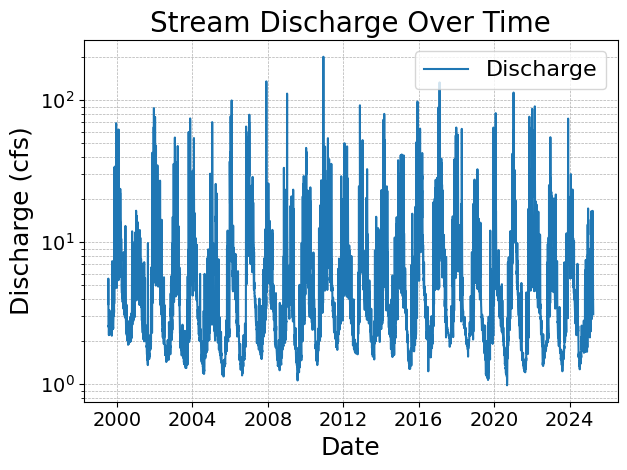

In [3]:
# Extract time series
dates = judd_data['Collect Date (local)']
discharge = judd_data['Discharge (cfs)'].values

# Create the plot
plt.figure()
plt.plot(dates, discharge, label='Discharge', color='tab:blue')

# Add labels and title
plt.xlabel('Date', fontsize=18)
plt.ylabel('Discharge (cfs)', fontsize=18)
plt.title('Stream Discharge Over Time', fontsize=20)

# Customize tick parameters
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add grid and legend
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=16)

# Improve layout
plt.tight_layout()
plt.yscale('log')
plt.show()


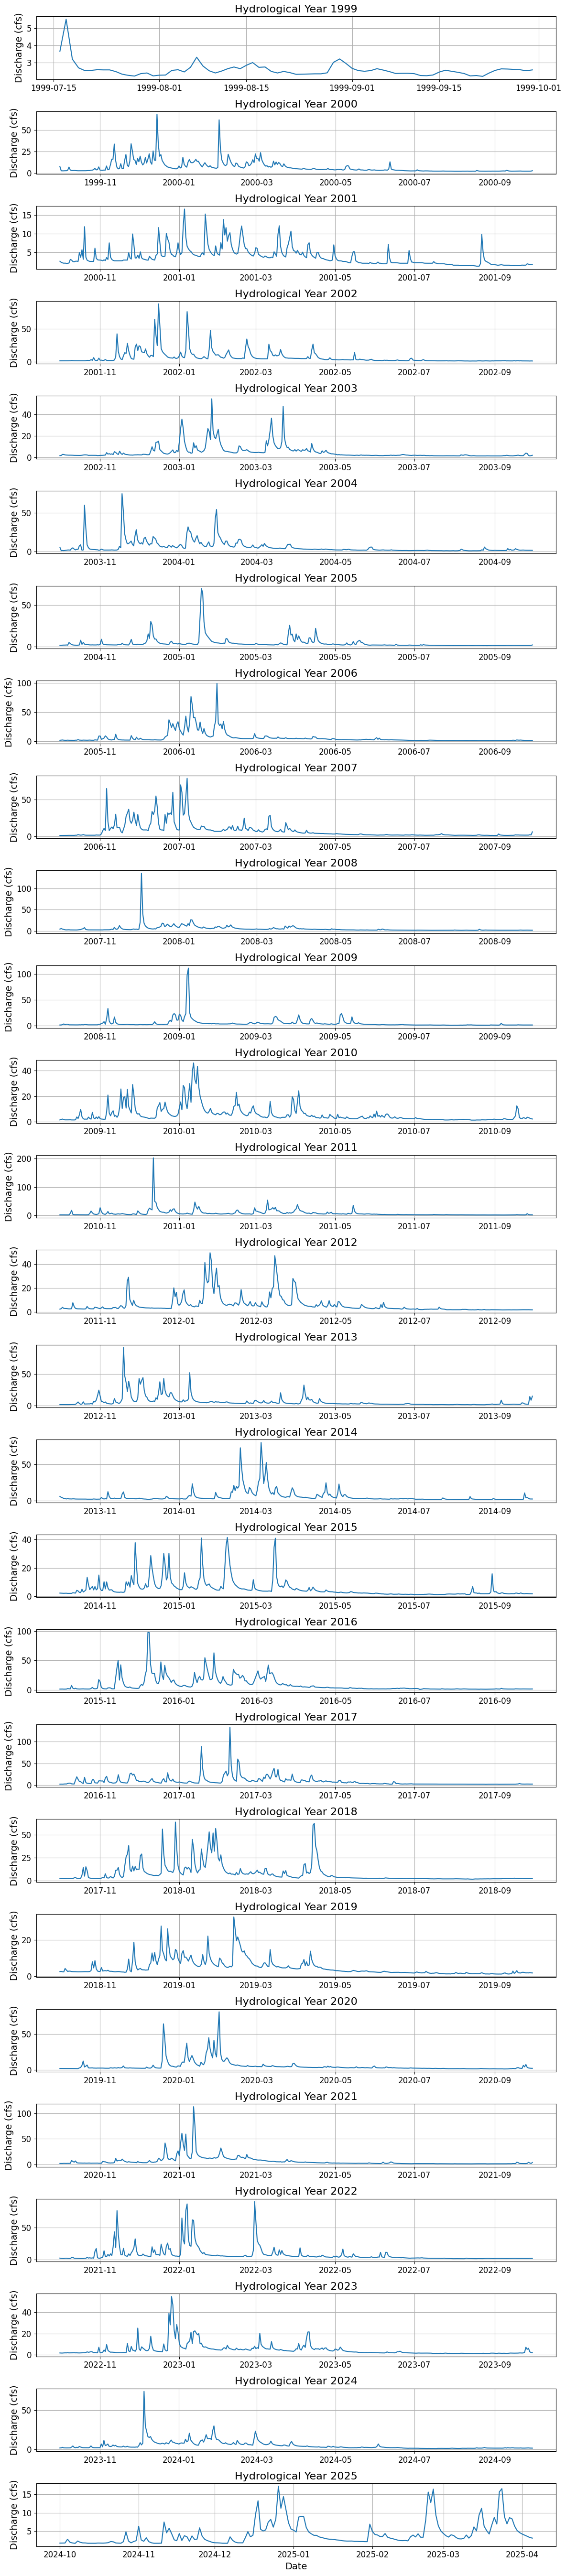

In [4]:
# Ensure the date column is in datetime format
dates = pd.to_datetime(judd_data['Collect Date (local)'])
discharge = judd_data['Discharge (cfs)'].values

# Create a DataFrame
df = pd.DataFrame({
    'Date': dates,
    'Discharge': discharge
})

# Define hydrological year: Oct 1 to Sept 30
def hydro_year(date):
    return date.year if date.month < 10 else date.year + 1

df['HydroYear'] = df['Date'].apply(hydro_year)

# Group by hydrological year
grouped = df.groupby('HydroYear')

# Create subplots
n_years = len(grouped)
fig, axes = plt.subplots(n_years, 1, figsize=(12, 2*n_years), sharex=False)

if n_years == 1:
    axes = [axes]  # Make sure axes is iterable

# Plot each year
for ax, (year, group) in zip(axes, grouped):
    ax.plot(group['Date'], group['Discharge'], color='tab:blue')
    ax.set_title(f'Hydrological Year {year}', fontsize=16)
    ax.set_ylabel('Discharge (cfs)', fontsize=14)
    ax.grid(True)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

axes[-1].set_xlabel('Date', fontsize=14)

plt.tight_layout()
plt.show()


/tmp/ipykernel_2320074/1163605522.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('cividis')


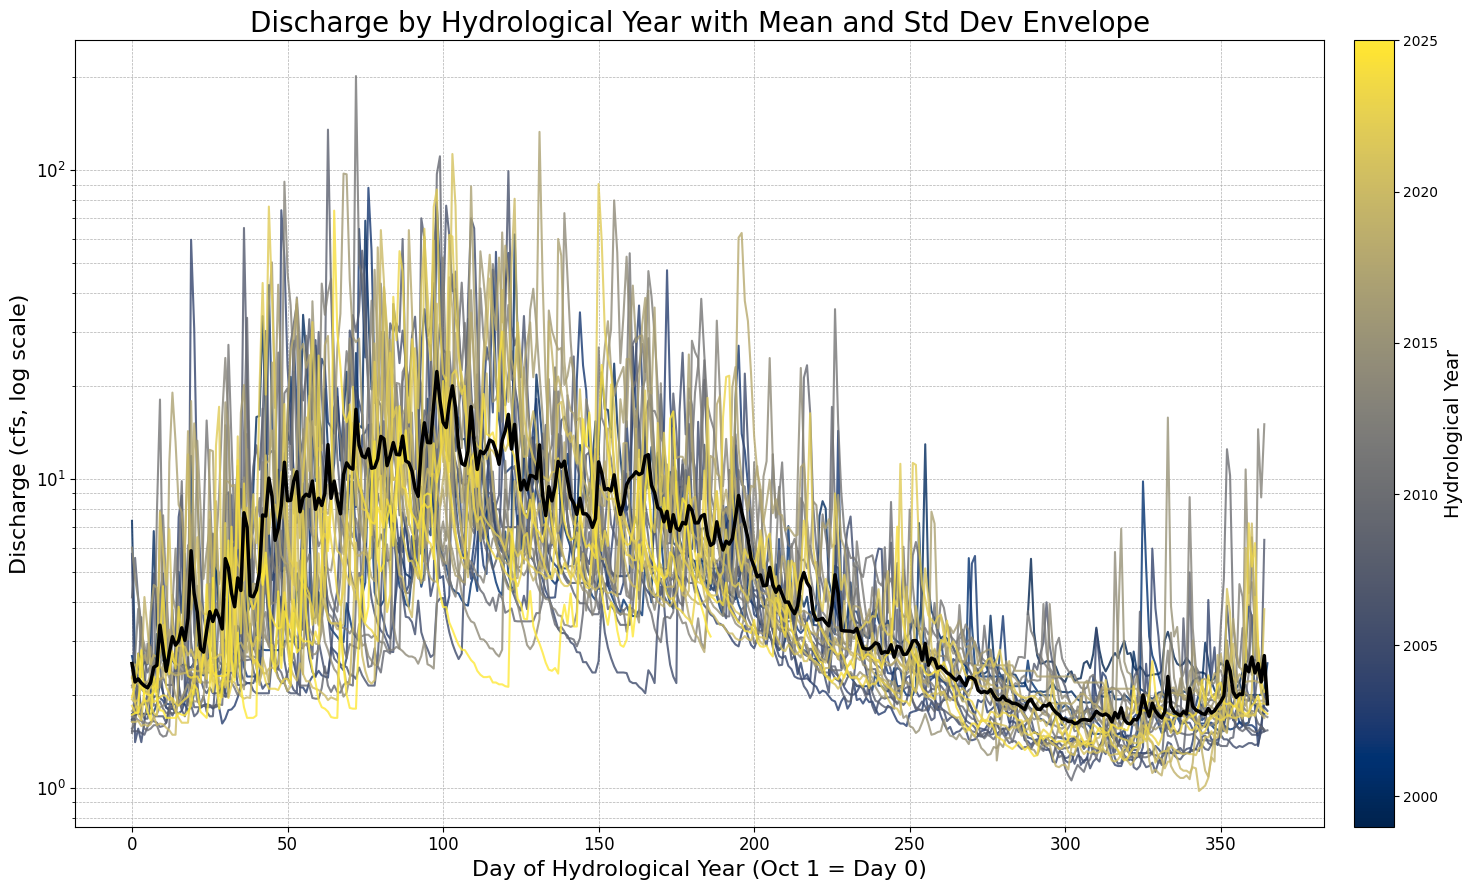

In [5]:
# Prepare data
dates = pd.to_datetime(judd_data['Collect Date (local)'])
discharge = judd_data['Discharge (cfs)'].values

df = pd.DataFrame({
    'Date': dates,
    'Discharge': discharge
})

def hydro_year(date):
    return date.year if date.month < 10 else date.year + 1

def hydro_day(date):
    hydro_start = pd.Timestamp(f"{hydro_year(date)-1}-10-01")
    return (date - hydro_start).days

df['HydroYear'] = df['Date'].apply(hydro_year)
df['HydroDay'] = df['Date'].apply(hydro_day)

# Pivot into a matrix: rows=days, columns=years
pivot = df.pivot(index='HydroDay', columns='HydroYear', values='Discharge')

# Prepare color mapping
years = pivot.columns
norm = mcolors.Normalize(vmin=years.min(), vmax=years.max())
cmap = cm.get_cmap('cividis')
colors = [cmap(norm(year)) for year in years]

# Plotting
fig, ax = plt.subplots(figsize=(16, 9))

# Plot each year's curve with color
for year, color in zip(years, colors):
    ax.plot(pivot.index, pivot[year], color=color, alpha=0.8, label=str(year))

# Compute and plot mean/std
mean_discharge = pivot.mean(axis=1)
std_discharge = pivot.std(axis=1)

ax.plot(pivot.index, mean_discharge, color='black', linewidth=2.5, label='Mean')
# ax.fill_between(pivot.index,
#                 mean_discharge - std_discharge,
#                 mean_discharge + std_discharge,
#                 color='black', alpha=0.2, label='±1 Std Dev')

# Axis and formatting
ax.set_yscale('log')
ax.set_xlabel('Day of Hydrological Year (Oct 1 = Day 0)', fontsize=16)
ax.set_ylabel('Discharge (cfs, log scale)', fontsize=16)
ax.set_title('Discharge by Hydrological Year with Mean and Std Dev Envelope', fontsize=20)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(labelsize=12)

# Add colorbar tied to dummy ScalarMappable
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Hydrological Year', fontsize=14)

# ax.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()


In [6]:
# import pandas as pd
# import numpy as np

# Make sure date column is datetime
df = pd.DataFrame({
    'Date': pd.to_datetime(judd_data['Collect Date (local)']),
    'Discharge': judd_data['Discharge (cfs)'].values
})

# Assign hydrological year
def hydro_year(date):
    return date.year if date.month < 10 else date.year + 1

df['HydroYear'] = df['Date'].apply(hydro_year)

# Sort just in case
df = df.sort_values('Date')

# Initialize list to collect results
results = []

# Group by hydrological year and integrate
for year, group in df.groupby('HydroYear'):
    these_dates = group['Date']
    flow = group['Discharge'].values

    # Time delta in seconds between samples
    delta_seconds = (these_dates.diff().dt.total_seconds()).fillna(0).values
    # Integrated volume in cubic feet
    volume_cubic_feet = np.sum(flow * delta_seconds)
    # Optionally convert to acre-feet (1 acre-foot = 43560 cubic feet)
    volume_acre_feet = volume_cubic_feet / 43560

    results.append({
        'HydroYear': year,
        'TotalVolume_cubic_feet': volume_cubic_feet,
        'TotalVolume_acre_feet': volume_acre_feet
    })

# Create DataFrame
annual_streamflow = pd.DataFrame(results)
annual_streamflow


,HydroYear,TotalVolume_cubic_feet,TotalVolume_acre_feet
0,1999,16803072.0,385.745455
1,2000,210234528.0,4826.320661
2,2001,120164256.0,2758.591736
3,2002,216224640.0,4963.834711
4,2003,153286560.0,3518.975207
5,2004,186596352.0,4283.662810
6,2005,125706816.0,2885.831405
7,2006,192707424.0,4423.953719
8,2007,254804832.0,5849.514050
9,2008,155136384.0,3561.441322


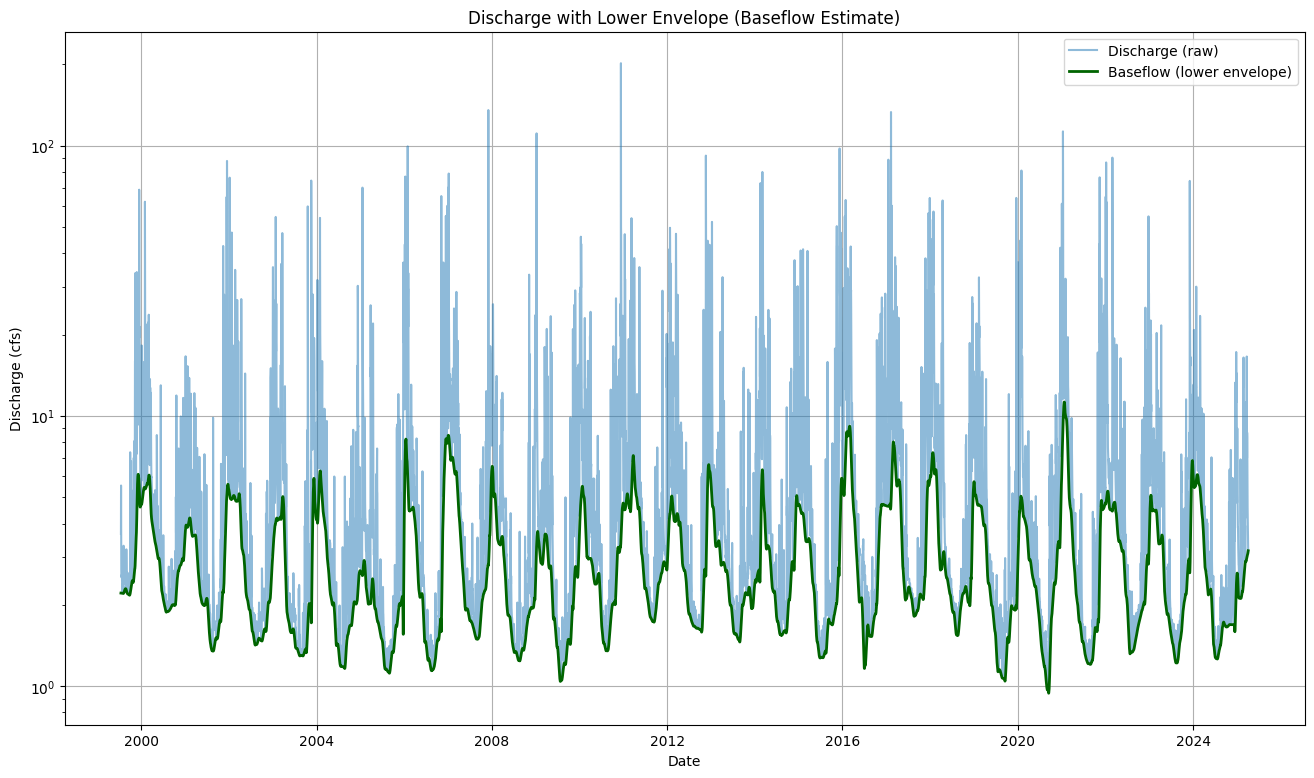

In [7]:
from scipy.ndimage import minimum_filter1d
from scipy.signal import savgol_filter



# Step 1: Rolling minimum to find the lower envelope
window_size = 30  # days (or samples) – adjust as needed
min_curve = minimum_filter1d(discharge, size=window_size)

# Step 2: Smooth the envelope to make it look nicer
smoothed_min_curve = savgol_filter(min_curve, window_length=31, polyorder=2)

# Plot
plt.subplots(figsize=(16, 9))
plt.plot(dates, discharge, label='Discharge (raw)', alpha=0.5)
plt.plot(dates, smoothed_min_curve, label='Baseflow (lower envelope)', color='darkgreen', linewidth=2)
plt.xlabel("Date")
plt.ylabel("Discharge (cfs)")
plt.title("Discharge with Lower Envelope (Baseflow Estimate)")
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()


In [8]:
import numpy as np
import pandas as pd
from scipy.ndimage import minimum_filter1d
from scipy.signal import savgol_filter

# Recreate baseflow envelope
window_size = 30  # rolling min window in days (or samples)
min_curve = minimum_filter1d(discharge, size=window_size)
smoothed_min_curve = savgol_filter(min_curve, window_length=31, polyorder=2)

# Build DataFrame for integration
df_baseflow = pd.DataFrame({
    'Date': pd.to_datetime(judd_data['Collect Date (local)']),
    'Discharge': discharge,
    'Baseflow': smoothed_min_curve
})

# Assign hydrological year
def hydro_year(date):
    return date.year if date.month < 10 else date.year + 1

df_baseflow['HydroYear'] = df_baseflow['Date'].apply(hydro_year)

# Compute integrated baseflow volume per hydrological year
baseflow_volumes = []

for year, group in df_baseflow.groupby('HydroYear'):
    dates = group['Date']
    baseflow = group['Baseflow'].values
    delta_seconds = dates.diff().dt.total_seconds().fillna(0).values
    baseflow_volume = np.sum(baseflow * delta_seconds)  # cubic feet
    baseflow_volumes.append({'HydroYear': year, 'BaseflowVolume_cubic_feet': baseflow_volume})

df_baseflow_summary = pd.DataFrame(baseflow_volumes)

# Merge with existing streamflow totals
hydrology = pd.merge(
    annual_streamflow[['HydroYear', 'TotalVolume_cubic_feet']],
    df_baseflow_summary,
    on='HydroYear',
    how='inner'
)

hydrology

,HydroYear,TotalVolume_cubic_feet,BaseflowVolume_cubic_feet
0,1999,16803072.0,1.458756e+07
1,2000,210234528.0,1.103346e+08
2,2001,120164256.0,8.138739e+07
3,2002,216224640.0,9.634729e+07
4,2003,153286560.0,7.465235e+07
5,2004,186596352.0,8.532883e+07
6,2005,125706816.0,5.940398e+07
7,2006,192707424.0,8.442076e+07
8,2007,254804832.0,1.180212e+08
9,2008,155136384.0,8.335764e+07


In [10]:
# Load the precipitation CSV file
precip_df = pd.read_csv('judd_creek_annual_precip_by_fraction.csv')

# Ensure the column used for merging is consistent
# Rename 'Hydro Year' to 'HydroYear' if necessary
precip_df.rename(columns={'Hydro Year': 'HydroYear'}, inplace=True)

# Merge with the hydrology DataFrame
merged_df = pd.merge(hydrology, precip_df, on='HydroYear', how='inner')

# Preview or save the merged result
# print(merged_df.head())

# Optionally save to a new CSV
merged_df.to_csv('judd_creek_hydrology_with_precip.csv', index=False, float_format='%.3f')
print("Merged CSV file 'judd_creek_hydrology_with_precip.csv' created successfully.")
merged_df

Merged CSV file 'judd_creek_hydrology_with_precip.csv' created successfully.


,HydroYear,TotalVolume_cubic_feet,BaseflowVolume_cubic_feet,Annual Precip (in) f=0.25,Annual Precip (in) f=0.50,Annual Precip (in) f=0.75
0,2005,125706816.0,5.940398e+07,33.800,35.670,37.540
1,2006,192707424.0,8.442076e+07,44.455,45.230,46.005
2,2007,254804832.0,1.180212e+08,51.462,52.325,53.187
3,2008,155136384.0,8.335764e+07,32.982,34.895,36.807
4,2009,150058656.0,6.783908e+07,35.562,36.035,36.508
5,2010,184386240.0,8.135449e+07,48.293,49.335,50.378
6,2011,250920288.0,1.108642e+08,47.118,48.635,50.152
7,2012,184530528.0,9.015172e+07,37.665,38.840,40.015
8,2013,200252736.0,8.991517e+07,46.530,47.960,49.390
9,2014,177315264.0,7.968840e+07,38.878,39.755,40.632


In [20]:
# Given watershed area
Area_Judd_Creek_acres = 3220
sqft_per_acre = 43560
in_to_ft = 1 / 12

# Conversion factor: inches of precip × this = volume in cubic feet
conversion_factor = Area_Judd_Creek_acres * sqft_per_acre * in_to_ft

# Identify precip columns
precip_columns = [col for col in merged_df.columns if col.startswith('Annual Precip (in)')]

# Start with full merged_df and add volume columns
full_df = merged_df.copy()

for col in precip_columns:
    volume_col = col.replace('Precip (in)', 'Precip (cu ft)')
    full_df[volume_col] = full_df[col] * conversion_factor

# Optional: save to CSV
# volume_df.to_csv('judd_creek_precip_volumes.csv', index=False, float_format='%.3f')

full_df=full_df.drop(columns=['Annual Precip (in) f=0.25','Annual Precip (in) f=0.50','Annual Precip (in) f=0.75'])
full_df=full_df.drop(columns=['Annual Precip (cu ft) f=0.25','Annual Precip (cu ft) f=0.50'])
full_df


,HydroYear,TotalVolume_cubic_feet,BaseflowVolume_cubic_feet,Annual Precip (cu ft) f=0.75
0,2005,125706816.0,5.940398e+07,438790044.0
1,2006,192707424.0,8.442076e+07,537734043.0
2,2007,254804832.0,1.180212e+08,621681568.2
3,2008,155136384.0,8.335764e+07,430222300.2
4,2009,150058656.0,6.783908e+07,426727408.8
5,2010,184386240.0,8.135449e+07,588848290.8
6,2011,250920288.0,1.108642e+08,586206667.2
7,2012,184530528.0,9.015172e+07,467719329.0
8,2013,200252736.0,8.991517e+07,577299954.0
9,2014,177315264.0,7.968840e+07,474931195.2


In [31]:
# Convert  back to inches averaged over the entire region!

# Create the new water budget DataFrame
water_budget = pd.DataFrame({
    'HydroYear': full_df['HydroYear'],
    'StreamFlow (in/yr)': full_df['TotalVolume_cubic_feet'] / conversion_factor,
    'BaseFlow (in/yr)': full_df['BaseflowVolume_cubic_feet'] / conversion_factor,
    'Precip (in/yr)': full_df['Annual Precip (cu ft) f=0.75'] / conversion_factor
})

def round_sig(x, sig=3):
    if pd.isnull(x):
        return x
    return round(x, sig - int(np.floor(np.log10(abs(x)))) - 1)

water_budget['Precip (in/yr)'] = water_budget['Precip (in/yr)'].apply(lambda x: round_sig(x, sig=3))
water_budget['StreamFlow (in/yr)'] = water_budget['StreamFlow (in/yr)'].apply(lambda x: round_sig(x, sig=3))
water_budget['BaseFlow (in/yr)'] = water_budget['BaseFlow (in/yr)'].apply(lambda x: round_sig(x, sig=3))
water_budget

,HydroYear,StreamFlow (in/yr),BaseFlow (in/yr),Precip (in/yr)
0,2005,10.8,5.08,37.5
1,2006,16.5,7.22,46.0
2,2007,21.8,10.10,53.2
3,2008,13.3,7.13,36.8
4,2009,12.8,5.80,36.5
5,2010,15.8,6.96,50.4
6,2011,21.5,9.48,50.2
7,2012,15.8,7.71,40.0
8,2013,17.1,7.69,49.4
9,2014,15.2,6.82,40.6
